# Figure out the magnitude limit of CPM method.

In [16]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import fits
plt.rcParams["figure.figsize"] = (14, 10)
from tess_stars2px import tess_stars2px_function_entry
import eleanor
import tess_rotation as tr
import starspot as ss

import warnings
warnings.filterwarnings('ignore')

from contextlib import contextmanager
import sys, os

@contextmanager
def suppress_stdout():
    with open(os.devnull, "w") as devnull:
        old_stdout = sys.stdout
        sys.stdout = devnull
        try:  
            yield
        finally:
            sys.stdout = old_stdout

Define functions for injection and recovery.

In [12]:
# Calculate counts for a star of a certain magnitude
def mag_to_counts(mag, seconds):
    """
    Convert stellar magnitude to electron counts.
    
    "15,000 e−/s for a star of m = 10: thus, a star of m = 5 will create 3 × 106 electrons in a two-second exposure"
    10 x fainter is a magnitude increase of 2.5 
    
    F2/F1 approx 2.5^(delta m)
    delta m = 1
    F2/F1 = 2.5
    
    delta m = log(F2/F1)/log(2.5)
    for F2/F1 = 10, delta m = 2.5
    
    For a change of 1 mag, the change in brightness is 2.5.
    For a change of 2.5 mag, the change in brightness is 10.
    For a change of 5 mag, the change in brightness is 100.
    """
    m = 10
    e = 15000
    delta_m = m - mag
    factor = 2.51**delta_m
    counts_per_sec = e * factor
    return counts_per_sec * seconds


# Inject a sinusoidal signal into each sector.
def inject_signal(ticid, period, amplitude, baseline, tesscut_path,
                  lower_sector_limit=0, upper_sector_limit=14, xpix=68, ypix=68):
    
    sectors, star = tr.get_sectors(ticid, lower_sector_limit=lower_sector_limit,
                                   upper_sector_limit=upper_sector_limit)

    # Eleanor object
    print("Finding Eleanor object...")
    for sector in sectors:
        print("sector", sector)

        print(ticid, sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        sec, camera, ccd, colrowpix = star.sector, star.camera, star.chip, star.position_on_chip
        ra, dec = star.coords
        
        fits_file = tr.get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec)
        
        path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(tesscut_path, ra, dec, xpix, ypix)
        inj_dir = "{0}/injected".format(path_to_tesscut)
        if not os.path.exists(inj_dir):
            os.mkdir(inj_dir)
        injection_filename = \
        "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
            inj_dir, str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)

        tr.inject_one_sector(ticid, sector, period, amplitude, baseline, sec,
                             camera, ccd, colrowpix, fits_file, injection_filename)
        

# Create CPM light curve from all sectors
def CPM_recover(ticid, tesscut_path, lower_sector_limit=0,
                upper_sector_limit=1000):

    print("Searching for observed sectors...")
    sectors, star = tr.get_sectors(ticid,
                                   lower_sector_limit=lower_sector_limit,
                                   upper_sector_limit=upper_sector_limit)
    print("sectors found: ", sectors)

    print("Creating light curve..")
    xs, ys = [], []
    for sector in sectors:
        print("sector", sector)
        star = eleanor.Source(tic=ticid, sector=int(sector), tc=True)
        x, y = CPM_one_sector(ticid, tesscut_path, sector, star.camera,
                              star.chip, star.coords[0], star.coords[1])
        xs.append(x)
        ys.append(y)

    return xs, ys, sectors


# Create CPM light curve for one sector.
def CPM_one_sector(ticid, tesscut_path, sector, camera, ccd, ra, dec, xpix=68, ypix=68):
    fits_file = tr.get_fits_filenames(tesscut_path, sector, camera, ccd, ra, dec,
                                      xpix=xpix, ypix=ypix)    
    path_to_tesscut = "{0}/astrocut_{1:12}_{2:13}_{3}x{4}px".format(tesscut_path, ra, dec, xpix, ypix)
    inj_dir = "{0}/injected".format(path_to_tesscut)
    injected_filename = "{0}/tess-s{1}-{2}-{3}_{4:.6f}_{5:.6f}_{6}x{7}_astrocut.fits".format(
        inj_dir, str(int(sector)).zfill(4), camera, ccd, ra, dec, xpix, ypix)

    # Create CPM light curve
    x, y = tr.make_lc_single_sector(sector, [33, 35], [33, 35], injected_filename,
                                    plot=False, save_to_file=False)
    return x, y

Download TESS cutouts.

In [7]:
ticid = 765143490
with suppress_stdout():
    sectors, _ = tr.get_sectors(ticid, upper_sector_limit=14)
print(sectors)

[ 1  2  4  5  6  7  8  9 10 11 12]


In [9]:
with suppress_stdout():
    tr.download_tess_cuts(ticid, lower_sector_limit=0, upper_sector_limit=14)

Inject into raw pixel data.

In [13]:
tesscut_path = "/Users/rangus/projects/TESS-rotation/data/TESScut/"
    
baseline = mag_to_counts(15, 2)
period, amplitude = 50, 3
with suppress_stdout():
    inject_signal(ticid, period, amplitude, baseline, tesscut_path)

Recover CPM light curve.

In [14]:
with suppress_stdout():
    time_cpm, flux_cpm, sectors = CPM_recover(ticid, tesscut_path, lower_sector_limit=0, upper_sector_limit=14)

Stitch light curve.

In [22]:
time, flux, flux_err = tr.stitch_light_curve(ticid, time_cpm, flux_cpm)

Fitting GP and offset model...


optimizing logp for variables: [step10, step9, step8, step7, step6, step5, step4, step3, step2, step1, logrho, logsigma]
132it [00:00, 752.06it/s, logp=4.205340e+03]
message: Desired error not necessarily achieved due to precision loss.
logp: 523.8426525573116 -> 4205.340178936562


Measure period

In [23]:
rotate = ss.RotationModel(time, flux-np.polyval(p, time), flux_err)
ls_period = rotate.ls_rotation(max_period=200.)
print(ls_period)

49.993625748974495


Plot light curve.

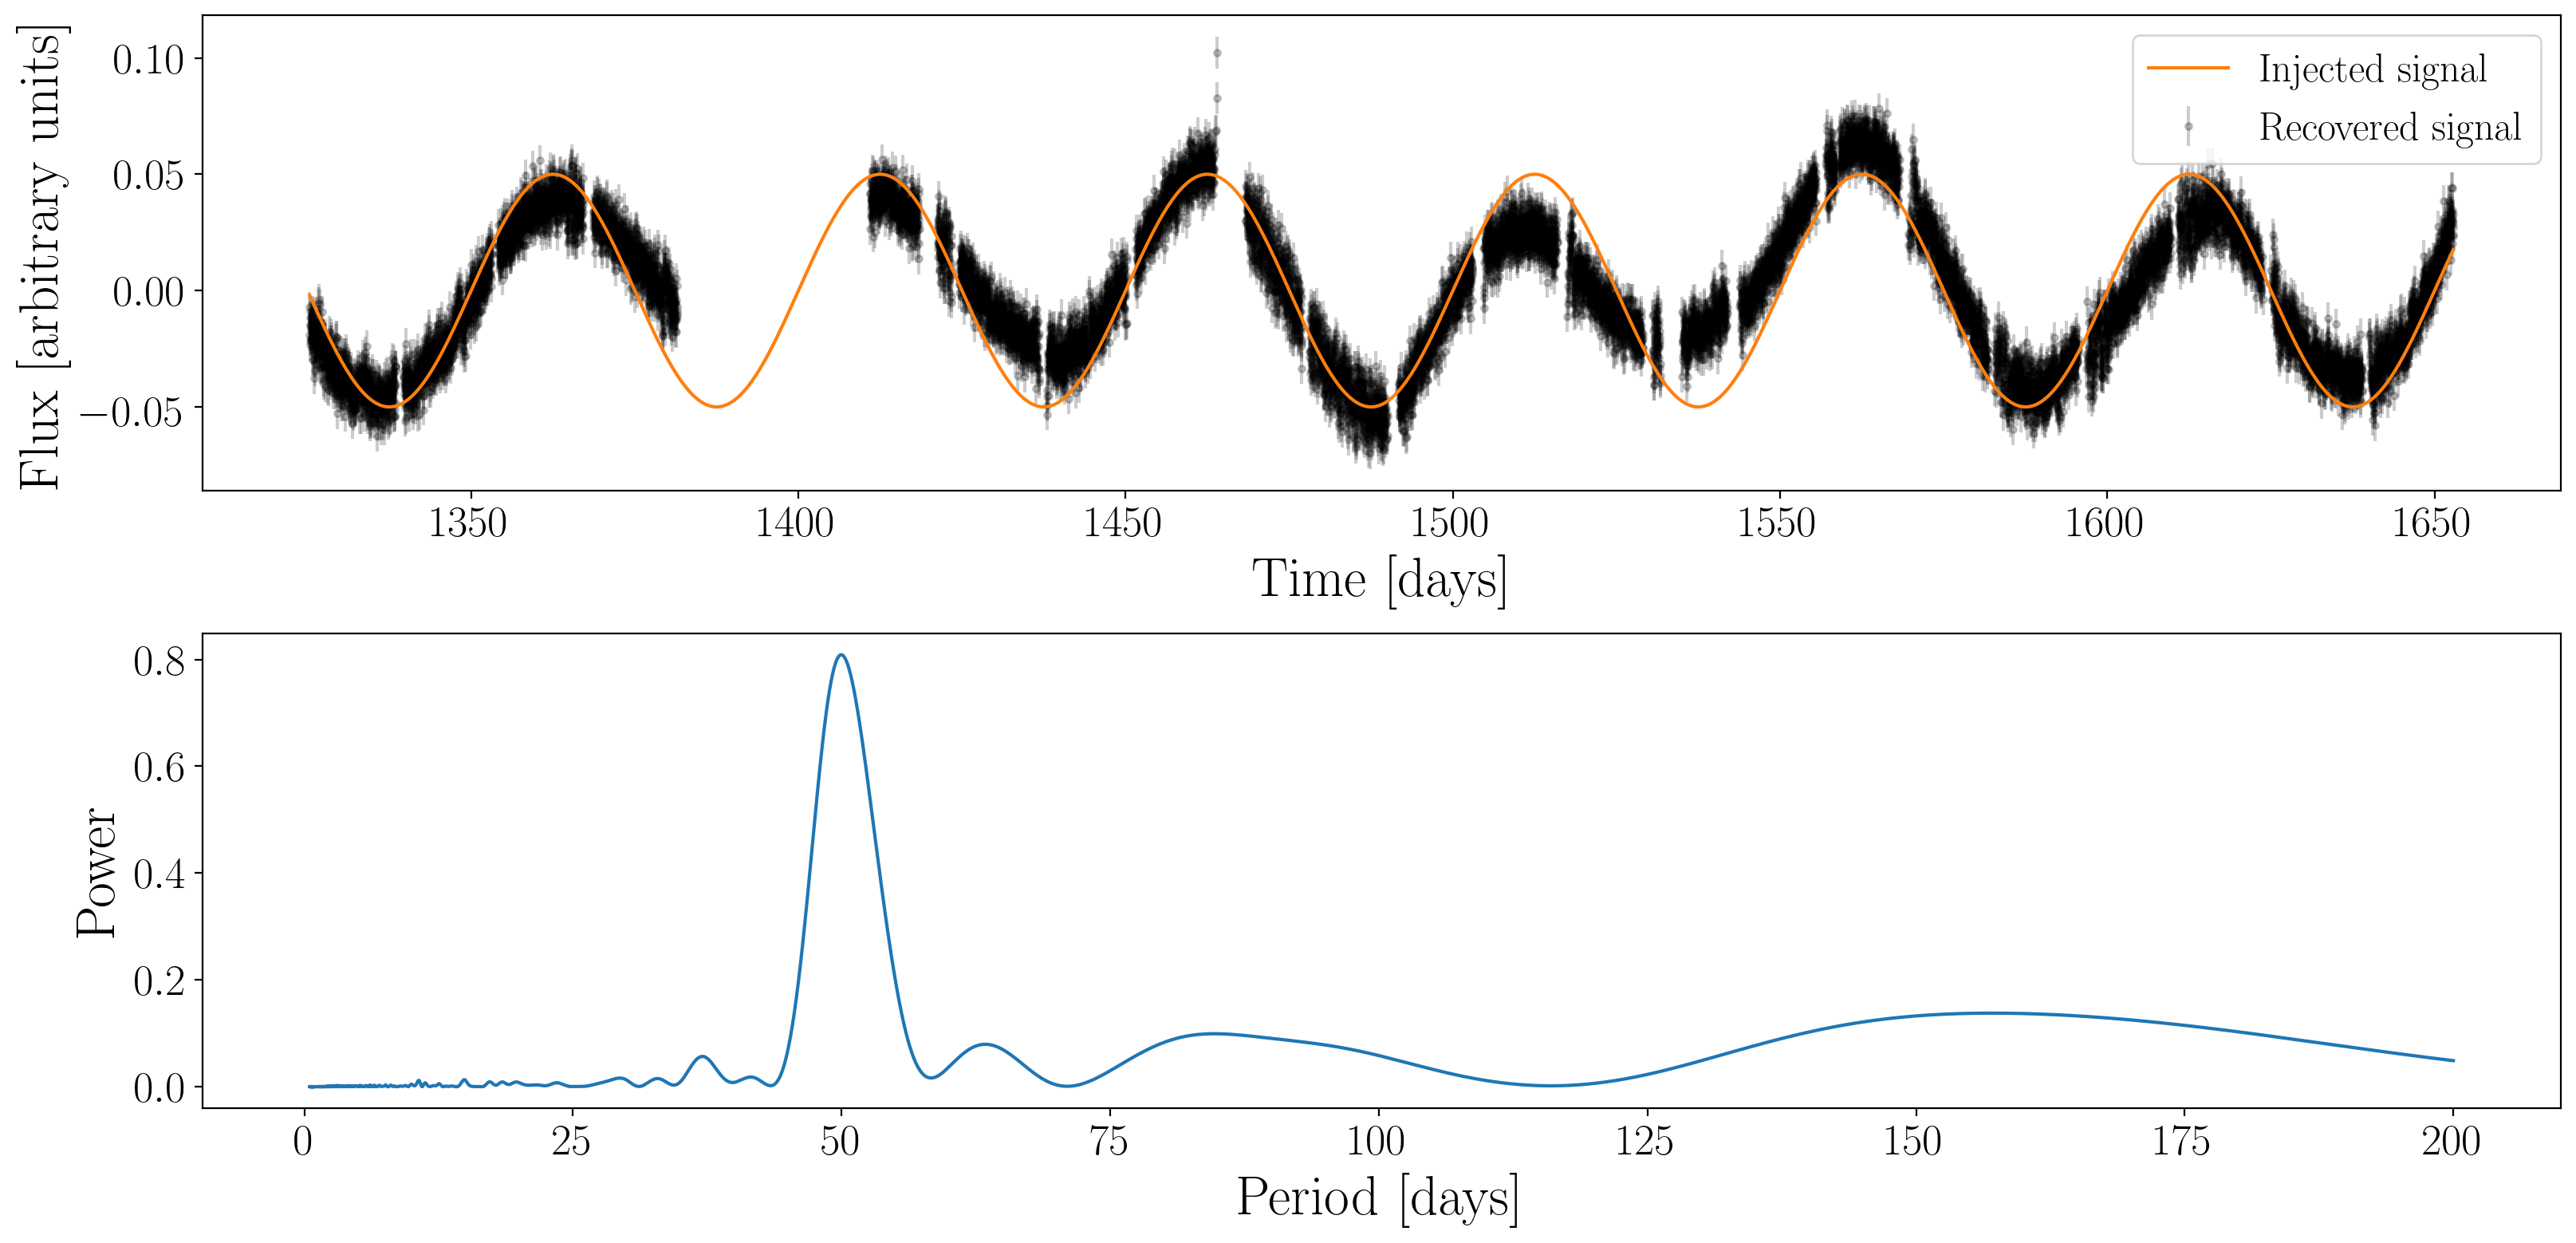

In [21]:
fig = plt.figure(figsize=(16, 8), dpi=200)
ax1 = fig.add_subplot(211)
p = np.polyfit(time, flux, 1)
xs = np.linspace(min(time), max(time), 1000)
ax1.errorbar(time, flux-np.polyval(p, time), yerr=flux_err, fmt="k.", alpha=.2, label="$\mathrm{Recovered~signal}$")
ax1.plot(xs, 0.05*np.sin(xs*2*np.pi/50), "C1", zorder=10, label="$\mathrm{Injected~signal}$")
ax1.legend(fontsize=18)
ax1.set_xlabel("$\mathrm{Time~[days]}$")
ax1.set_ylabel("$\mathrm{Flux~[arbitrary~units]}$");

ax2 = fig.add_subplot(212)
ax2.plot(1./rotate.freq, rotate.power)
ax2.set_xlabel("$\mathrm{Period~[days]}$")
ax2.set_ylabel("$\mathrm{Power}$");

plt.tight_layout()